## Libraries that need to be imported

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import os

## Loading and preprocessing data

In [20]:
# Load dataset from CSV
def load_fashion_mnist(csv_path):
    data = pd.read_csv(csv_path).values
    labels = data[:, 0]
    images = data[:, 1:]

    # Normalize pixel values to [0,1]
    images = images.astype(np.float32) / 255.0

    return images, labels

# Load train and test datasets
x_train, y_train = load_fashion_mnist("datasets/fashion-mnist_train.csv")
x_test, y_test = load_fashion_mnist("datasets/fashion-mnist_test.csv")

x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

def one_hot_encode(y, num_classes=10):
    y = y.astype(int)
    one_hot = np.zeros((y.shape[0], num_classes))
    one_hot[np.arange(y.shape[0]), y] = 1
    return one_hot

# One-hot encode the labels
y_train = one_hot_encode(y_train)
y_val = one_hot_encode(y_val)
y_test = one_hot_encode(y_test)

print("Train dataset shape:", x_train.shape, y_train.shape)
print("Validation dataset shape:", x_val.shape, y_val.shape)
print("Test dataset shape:", x_test.shape, y_test.shape)

Train dataset shape: (48000, 784) (48000, 10)
Validation dataset shape: (12000, 784) (12000, 10)
Test dataset shape: (10000, 784) (10000, 10)


## Defining Helping Functions

### defining various Activation functions

In [32]:
# Activation functions
def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    return np.where(Z > 0, 1, 0)

def leaky_relu(Z, alpha=0.01):
    return np.where(Z > 0, Z, alpha * Z)

def leaky_relu_derivative(Z, alpha=0.01):
    return np.where(Z > 0, 1, alpha)

def tanh(Z):
    return np.tanh(Z)

def tanh_derivative(Z):
    return 1 - np.tanh(Z) ** 2

def gelu(Z):
    return 0.5 * Z * (1 + np.tanh(np.sqrt(2 / np.pi) * (Z + 0.044715 * Z ** 3)))

def gelu_derivative(Z):
    return 0.5 * (1 + np.tanh(np.sqrt(2 / np.pi) * (Z + 0.044715 * Z ** 3))) + (Z * (1 - np.tanh(np.sqrt(2 / np.pi) * (Z + 0.044715 * Z ** 3)) ** 2) * (np.sqrt(2 / np.pi) * (1 + 3 * 0.044715 * Z ** 2)) * 0.5)

def softmax(Z):
    expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    return expZ / np.sum(expZ, axis=1, keepdims=True)

def cross_entropy_loss(Y_true, Y_pred):
    return -np.mean(np.sum(Y_true * np.log(Y_pred + 1e-9), axis=1))

def get_activation_functions():
    """Return dictionary of activation functions and their derivatives"""
    return {
        'relu': (relu, relu_derivative),
        'leaky_relu': (leaky_relu, leaky_relu_derivative),
        'tanh': (tanh, tanh_derivative),
        'gelu': (gelu, gelu_derivative)
    }

### Forward and Backward pass functions

In [22]:
def forward_pass(X, network_weights, dropout_rate=0.2, activation_function=gelu):
    """
    network_weights: list of tuples (W, b) for each set of weights.
    layer_outputs: list of tuples (Z, A, mask) for each layer.
    For the output layer, mask is None.
    """
    layer_outputs = []
    A = X
    for i, (W, b) in enumerate(network_weights):
        Z = np.matmul(A, W) + b
        if i == len(network_weights) - 1:
            A = softmax(Z)
            mask = None
        else:
            A = activation_function(Z)
            mask = (np.random.rand(*A.shape) > dropout_rate)
            A = A * mask / (1 - dropout_rate)
        layer_outputs.append((Z, A, mask))
    return layer_outputs

In [23]:
def backward_pass(X, Y, network_weights, layer_outputs, dropout_rate=0.2, learning_rate=0.05, activation_derivative=gelu_derivative):
    """
    X, Y
    network_weights: List of (W, b) tuples.
    layer_outputs: List of (Z, A, mask) tuples afer the forward pass.
    Returns updated list of network_weights.
    """
    m = X.shape[0]
    L = len(network_weights)
    grads = [None] * L

    ZL, AL, _ = layer_outputs[-1] # '_' to ignore mask of output layer
    dZ = AL - Y

    A_prev = layer_outputs[-2][1] if L > 1 else X  # if-else to handle one layer case
    dW = np.matmul(A_prev.T, dZ) / m
    db = np.mean(dZ, axis=0, keepdims=True)
    grads[-1] = (dW, db) # gradient of last layer

    dA_prev = np.matmul(dZ, network_weights[-1][0].T)


    for i in reversed(range(L - 1)):
        Z, A, mask = layer_outputs[i] # same mask of forward pass
        A_prev = X if i == 0 else layer_outputs[i-1][1]

        dA = dA_prev * mask / (1 - dropout_rate)
        dZ = dA * activation_derivative(Z)
        dW = np.matmul(A_prev.T, dZ) / m
        db = np.mean(dZ, axis=0, keepdims=True)
        grads[i] = (dW, db)

        dA_prev = np.matmul(dZ, network_weights[i][0].T) #dA_prev for next layer


    #weights update
    for i in range(L):
        W, b = network_weights[i]
        dW, db = grads[i]
        network_weights[i] = (W - learning_rate * dW, b - learning_rate * db)

    return network_weights

### Initialising network weights and biases

In [ ]:
def create_network_weights(layer_dims, init_scale=0.01):
    """
    Create network weights for given architecture
    layer_dims: list of integers representing number of neurons in each layer
    """
    network_weights = []
    for i in range(1, len(layer_dims)):
        W = np.random.randn(layer_dims[i-1], layer_dims[i]) * init_scale
        b = np.zeros((1, layer_dims[i]))
        network_weights.append((W, b))
    return network_weights


### Training and Predicting functions

In [25]:
def predict(X, network_weights):
    layer_outputs = forward_pass(X, network_weights, dropout_rate=0)  # No dropout at test time
    return np.argmax(layer_outputs[-1][1], axis=1)

In [26]:
def train_network(x_train, y_train, x_val, y_val, config):
    """
    Train network with given configuration
    config: dictionary containing hyperparameters
    """
    network_weights = create_network_weights(config['layer_dims'])

    loss_array = []
    prev_loss = float('inf')
    accuracy_array = []
    learning_rate = config['learning_rate']

    for epoch in range(config['epochs']):
        if epoch % 10 == 0:
            print(f"  Epoch {epoch}/{config['epochs']}")

        indices = np.random.permutation(x_train.shape[0])
        x_train_shuffled = x_train[indices]
        y_train_shuffled = y_train[indices]

        epoch_loss = 0
        for i in range(0, x_train.shape[0], config['batch_size']):
            X_batch = x_train_shuffled[i:i+config['batch_size']]
            Y_batch = y_train_shuffled[i:i+config['batch_size']]

            # Forward pass
            layer_outputs = forward_pass(
                X_batch,
                network_weights,
                dropout_rate=config['dropout_rate'],
                activation_function=config['activation']
            )

            Y_pred = layer_outputs[-1][1]
            loss = cross_entropy_loss(Y_batch, Y_pred)
            epoch_loss += loss

            # Backward pass
            network_weights = backward_pass(
                X_batch,
                Y_batch,
                network_weights,
                layer_outputs,
                dropout_rate=config['dropout_rate'],
                learning_rate=learning_rate,
                activation_derivative=config['activation_derivative']
            )

        loss_array.append(epoch_loss)

        if epoch_loss > prev_loss:
            learning_rate /= 2

        prev_loss = epoch_loss

        # Calculate validation accuracy every 5 epochs
        if (epoch + 1) % 5 == 0:
            y_pred = predict(x_val, network_weights)
            y_true = np.argmax(y_val, axis=1)
            accuracy = np.mean(y_pred == y_true)
            accuracy_array.append(accuracy)
            print(f"  Epoch {epoch+1}: Accuracy = {accuracy:.4f}, Loss = {epoch_loss:.4f}")

    # Calculate final validation accuracy
    y_pred = predict(x_val, network_weights)
    y_true = np.argmax(y_val, axis=1)
    final_accuracy = np.mean(y_pred == y_true)

    return {
        'final_loss': epoch_loss,
        'final_accuracy': final_accuracy,
        'loss_history': loss_array,
        'accuracy_history': accuracy_array,
        'network_weights': network_weights
    }

## Trying Various Hyperparameter combinations

### Comparing different combinations of hyperparameters

In [ ]:
def run_hyperparameter_search_sequential():
    results = {}

    # Default configuration
    default_config = {
        'layer_dims': [784, 128, 64, 10],  # default architecture
        'activation': gelu,
        'activation_derivative': gelu_derivative,
        'dropout_rate': 0.2,
        'batch_size': 32,
        'learning_rate': 0.05,
        'epochs': 10
    }

    # Phase 1: Test different architectures
    print("\n=== Phase 1: Testing Different Architectures ===")
    layer_architectures = [
        [784, 128, 64, 10],    # 2 hidden layers
        [784, 64, 32, 10],     # 2 hidden layers
        [784, 256, 128, 64, 10],  # 3 hidden layers
        [784, 128, 64, 32, 10],   # 3 hidden layers
    ]

    architecture_results = {}
    for architecture in layer_architectures:
        config = default_config.copy()
        config['layer_dims'] = architecture
        name = f"layers_{len(architecture)-2}_neurons_{architecture[1]}"
        print(f"\nTesting architecture: {name}")

        result = train_network(x_train, y_train, x_val, y_val, config)
        architecture_results[name] = result
        print(f"Accuracy: {result['final_accuracy']:.4f}")

    # Find best architecture
    best_arch = max(architecture_results.items(), key=lambda x: x[1]['final_accuracy'])
    best_architecture = layer_architectures[list(architecture_results.keys()).index(best_arch[0])]
    print(f"\nBest architecture: {best_arch[0]} with accuracy {best_arch[1]['final_accuracy']:.4f}")

    # Update default config with best architecture
    default_config['layer_dims'] = best_architecture
    results['architecture_results'] = architecture_results

    # Phase 2: Test activation functions
    print("\n=== Phase 2: Testing Activation Functions ===")
    activation_functions = get_activation_functions()
    activation_results = {}

    for act_name, (act_func, act_deriv) in activation_functions.items():
        config = default_config.copy()
        config['activation'] = act_func
        config['activation_derivative'] = act_deriv
        print(f"\nTesting activation: {act_name}")

        result = train_network(x_train, y_train, x_val, y_val, config)
        activation_results[act_name] = result
        print(f"Accuracy: {result['final_accuracy']:.4f}")

    # Find best activation
    best_act = max(activation_results.items(), key=lambda x: x[1]['final_accuracy'])
    print(f"\nBest activation: {best_act[0]} with accuracy {best_act[1]['final_accuracy']:.4f}")

    # Update default config with best activation
    default_config['activation'] = activation_functions[best_act[0]][0]
    default_config['activation_derivative'] = activation_functions[best_act[0]][1]
    results['activation_results'] = activation_results

    # Phase 3: Test dropout rates
    print("\n=== Phase 3: Testing Dropout Rates ===")
    dropout_rates = [0.0, 0.2, 0.3, 0.4]
    dropout_results = {}

    for dropout_rate in dropout_rates:
        config = default_config.copy()
        config['dropout_rate'] = dropout_rate
        print(f"\nTesting dropout rate: {dropout_rate}")

        result = train_network(x_train, y_train, x_val, y_val, config)
        dropout_results[str(dropout_rate)] = result
        print(f"Accuracy: {result['final_accuracy']:.4f}")

    # Find best dropout rate
    best_dropout = max(dropout_results.items(), key=lambda x: x[1]['final_accuracy'])
    print(f"\nBest dropout rate: {best_dropout[0]} with accuracy {best_dropout[1]['final_accuracy']:.4f}")

    results['dropout_results'] = dropout_results

    return results

In [28]:
def analyze_sequential_results(results):
    # Create separate dataframes for each phase
    df_arch = pd.DataFrame([
        {
            'name': name,
            'accuracy': data['final_accuracy'],
            'loss': data['final_loss']
        }
        for name, data in results['architecture_results'].items()
    ])

    df_act = pd.DataFrame([
        {
            'name': name,
            'accuracy': data['final_accuracy'],
            'loss': data['final_loss']
        }
        for name, data in results['activation_results'].items()
    ])

    df_dropout = pd.DataFrame([
        {
            'name': name,
            'accuracy': data['final_accuracy'],
            'loss': data['final_loss']
        }
        for name, data in results['dropout_results'].items()
    ])

    return df_arch, df_act, df_dropout

### Plotting results

In [29]:
def plot_sequential_results(df_arch, df_act, df_dropout):
    fig, axes = plt.subplots(3, 1, figsize=(10, 15))

    # Function to add value labels on bars
    def add_value_labels(ax, precision=4):
        for p in ax.patches:
            value = p.get_height()
            ax.annotate(f'{value:.{precision}f}',
                       (p.get_x() + p.get_width()/2, value),
                       ha='center', va='bottom')

    # Plot architecture results
    sns.barplot(data=df_arch, x='name', y='accuracy', ax=axes[0])
    axes[0].set_title('Accuracy by Architecture')
    axes[0].tick_params(axis='x', rotation=45)
    add_value_labels(axes[0])

    # Plot activation results
    sns.barplot(data=df_act, x='name', y='accuracy', ax=axes[1])
    axes[1].set_title('Accuracy by Activation Function')
    add_value_labels(axes[1])

    # Plot dropout results
    sns.barplot(data=df_dropout, x='name', y='accuracy', ax=axes[2])
    axes[2].set_title('Accuracy by Dropout Rate')
    add_value_labels(axes[2])

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

    # Print the best configurations
    print("\nBest Configurations:")
    print(f"Best Architecture: {df_arch.loc[df_arch['accuracy'].idxmax(), 'name']} "
          f"(Accuracy: {df_arch['accuracy'].max():.4f})")
    print(f"Best Activation: {df_act.loc[df_act['accuracy'].idxmax(), 'name']} "
          f"(Accuracy: {df_act['accuracy'].max():.4f})")
    print(f"Best Dropout Rate: {df_dropout.loc[df_dropout['accuracy'].idxmax(), 'name']} "
          f"(Accuracy: {df_dropout['accuracy'].max():.4f})")


=== Phase 1: Testing Different Architectures ===

Testing architecture: layers_2_neurons_128
  Epoch 0/10
  Epoch 5: Accuracy = 0.8538, Loss = 584.8932
  Epoch 10: Accuracy = 0.8786, Loss = 496.3329
Accuracy: 0.8786

Testing architecture: layers_2_neurons_64
  Epoch 0/10
  Epoch 5: Accuracy = 0.8620, Loss = 646.2525
  Epoch 10: Accuracy = 0.8735, Loss = 557.2845
Accuracy: 0.8735

Testing architecture: layers_3_neurons_256
  Epoch 0/10
  Epoch 5: Accuracy = 0.8686, Loss = 569.0739
  Epoch 10: Accuracy = 0.8808, Loss = 477.8457
Accuracy: 0.8808

Testing architecture: layers_3_neurons_128
  Epoch 0/10
  Epoch 5: Accuracy = 0.8672, Loss = 622.2700
  Epoch 10: Accuracy = 0.8802, Loss = 523.2930
Accuracy: 0.8802

Best architecture: layers_3_neurons_256 with accuracy 0.8808

=== Phase 2: Testing Activation Functions ===

Testing activation: relu
  Epoch 0/10
  Epoch 5: Accuracy = 0.8451, Loss = 597.0375
  Epoch 10: Accuracy = 0.8508, Loss = 507.1482
Accuracy: 0.8508

Testing activation: leak

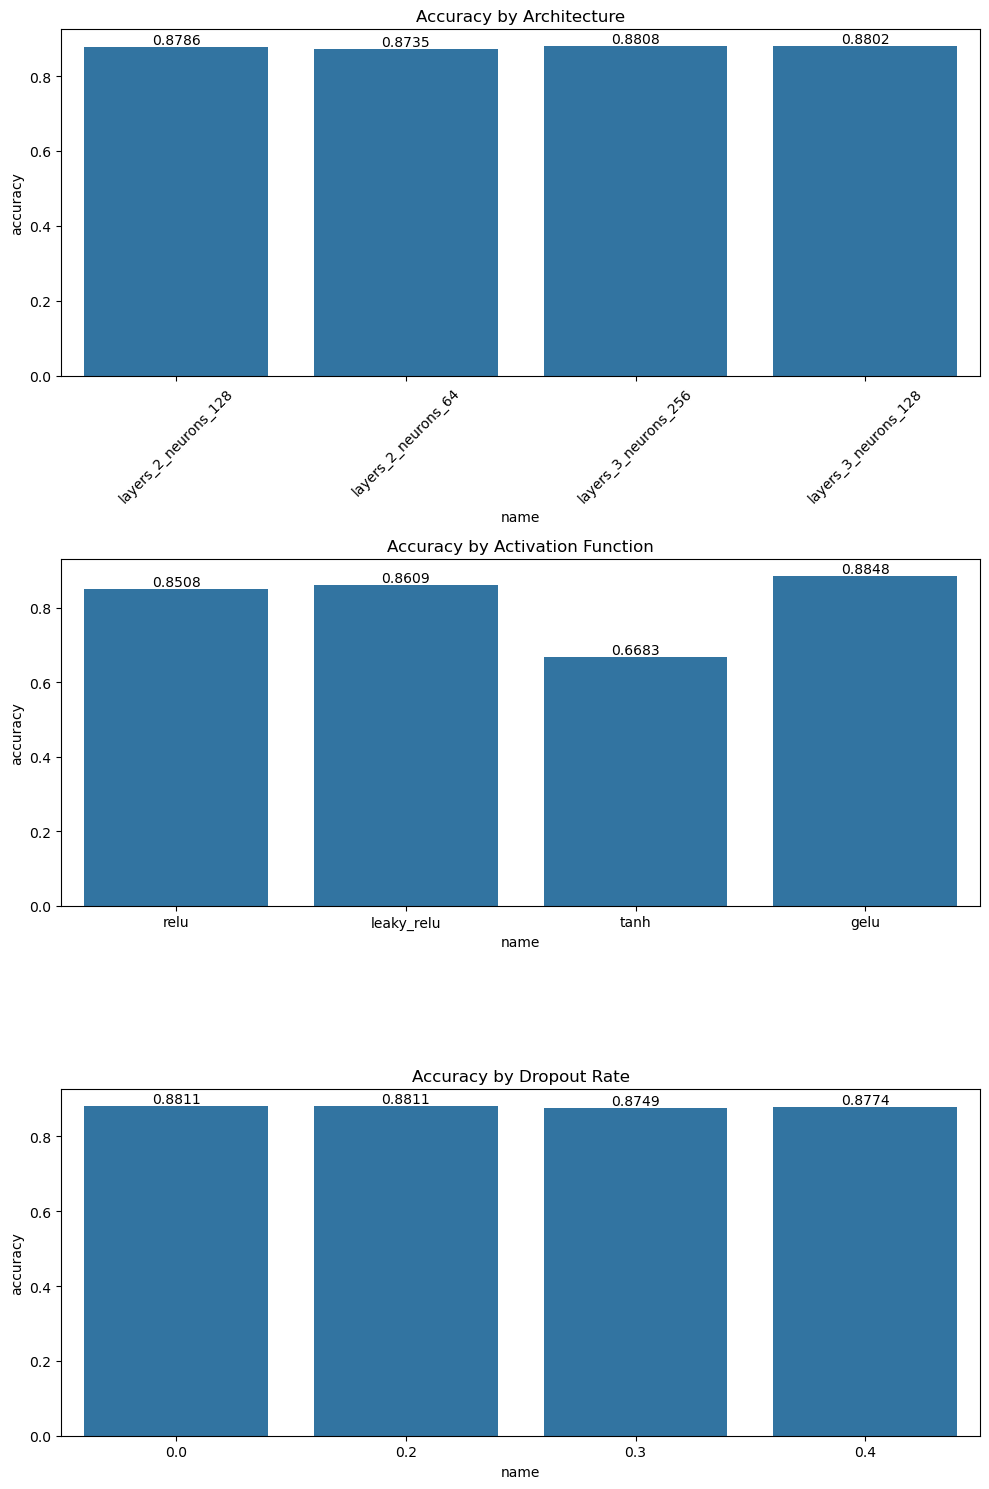


Best Configurations:
Best Architecture: layers_3_neurons_256 (Accuracy: 0.8808)
Best Activation: gelu (Accuracy: 0.8848)
Best Dropout Rate: 0.0 (Accuracy: 0.8811)

Results by Architecture:
                   name  accuracy        loss
0  layers_2_neurons_128  0.878583  496.332868
1   layers_2_neurons_64  0.873500  557.284523
2  layers_3_neurons_256  0.880750  477.845716
3  layers_3_neurons_128  0.880250  523.292998

Results by Activation Function:
         name  accuracy        loss
0        relu  0.850833  507.148155
1  leaky_relu  0.860917  503.695039
2        tanh  0.668250  556.419224
3        gelu  0.884833  474.630794

Results by Dropout Rate:
  name  accuracy        loss
0  0.0  0.881083  376.160006
1  0.2  0.881083  478.520845
2  0.3  0.874917  524.684979
3  0.4  0.877417  573.079533


In [13]:
# Run experiments
results = run_hyperparameter_search_sequential()

# Analyze and visualize results
df_arch, df_act, df_dropout = analyze_sequential_results(results)
plot_sequential_results(df_arch, df_act, df_dropout)

print("\nResults by Architecture:")
print(df_arch)

print("\nResults by Activation Function:")
print(df_act)

print("\nResults by Dropout Rate:")
print(df_dropout)


## Best Model training

### Best hyperparameters Model 


Training final model with best and optimal hyperparameters:
Architecture: [784, 128, 64, 10]
Activation: gelu
Dropout Rate: 0.2
  Epoch 0/50
  Epoch 5: Accuracy = 0.8438, Loss = 664.0010
  Epoch 10: Accuracy = 0.8689, Loss = 540.3931
  Epoch 10/50
  Epoch 15: Accuracy = 0.8793, Loss = 480.7930
  Epoch 20: Accuracy = 0.8824, Loss = 437.8344
  Epoch 20/50
  Epoch 25: Accuracy = 0.8868, Loss = 405.7826
  Epoch 30: Accuracy = 0.8867, Loss = 382.9741
  Epoch 30/50
  Epoch 35: Accuracy = 0.8896, Loss = 357.3350
  Epoch 40: Accuracy = 0.8958, Loss = 313.3446
  Epoch 40/50
  Epoch 45: Accuracy = 0.8982, Loss = 290.6329
  Epoch 50: Accuracy = 0.8968, Loss = 276.3795

Final Model Performance:
Validation Accuracy: 0.8968
Final Loss: 276.3795


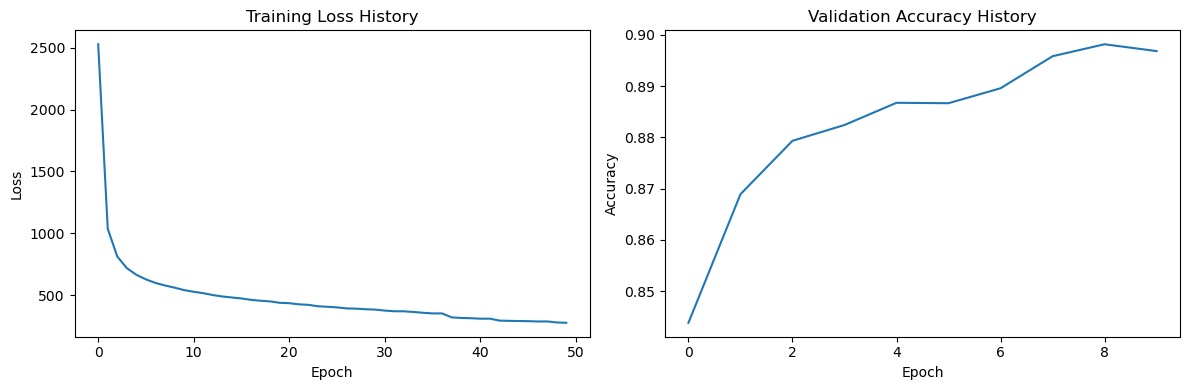

In [30]:
# Train final model with best hyperparameters
best_config = {
    'layer_dims': [784, 128, 64, 10],  # Use the architecture directly based on best results
    'activation': gelu,
    'activation_derivative': gelu_derivative,
    'dropout_rate': 0.2,
    'batch_size': 32,
    'learning_rate': 0.05,
    'epochs': 50
}

print("\nTraining final model with best and optimal hyperparameters:")
print(f"Architecture: {best_config['layer_dims']}")
print(f"Activation: {best_config['activation'].__name__}")
print(f"Dropout Rate: {best_config['dropout_rate']}")

final_result = train_network(x_train, y_train, x_val, y_val, best_config)

print(f"\nFinal Model Performance:")
print(f"Validation Accuracy: {final_result['final_accuracy']:.4f}")
print(f"Final Loss: {final_result['final_loss']:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(final_result['loss_history'])
plt.title('Training Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(final_result['accuracy_history'])
plt.title('Validation Accuracy History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

### Prediction on Test dataset

Test Accuracy: 0.9010


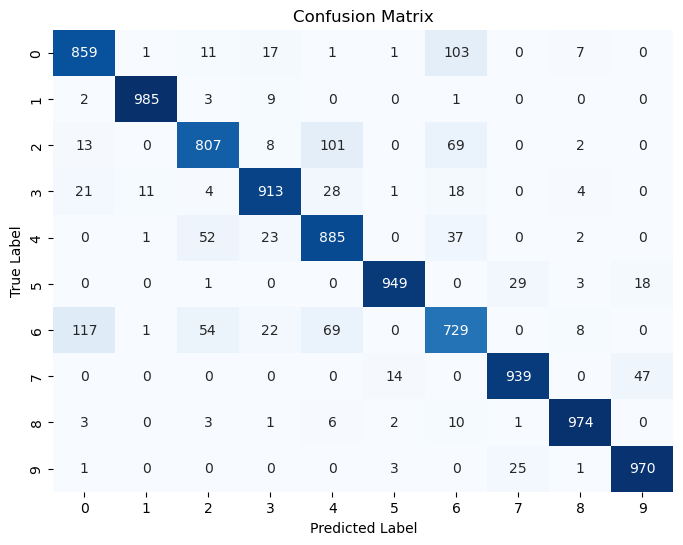

In [31]:
# Evaluate on test set
y_pred = predict(x_test, final_result['network_weights'])
y_true = np.argmax(y_test, axis=1)
test_accuracy = np.mean(y_pred == y_true)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
